In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = ['FEDBANK', 'FEDVOL', 'SBI', 'BAJAJFIN', 'ICICI']
target_column = ['FEDBANK']
features = df[feature_columns]
target = df[target_column].shift(-2)

new_data1 = 152.35
target.iloc[-2, 0] = new_data1

new_data2 = 154.05
target.iloc[-1, 0] = new_data2
target.tail(5)


,FEDBANK
3748,149.800003
3749,149.800003
3750,150.199997
3751,152.350000
3752,154.050000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5 # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_fedbk2h_0.9754.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9754
MAPE: 0.0282
RMSE: 3.9586
RMSE_normalizeddata: 0.0259
MAE_normalizeddata: 0.0201
MAE: 3.0761


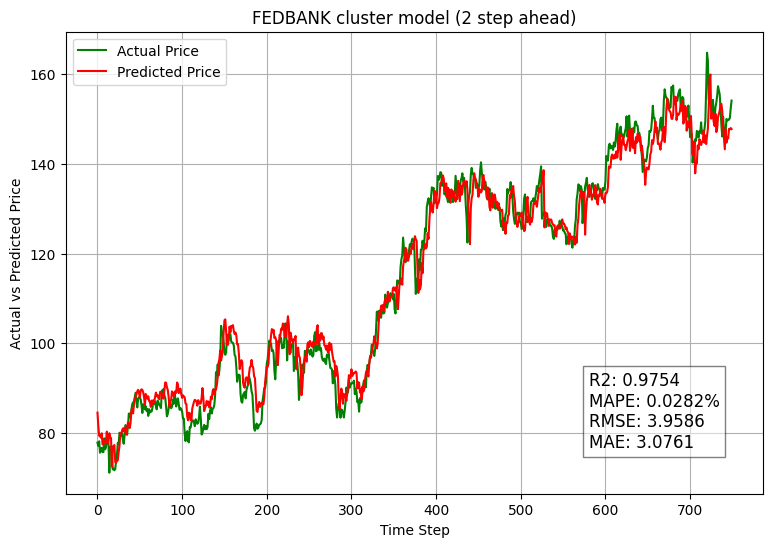

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('FEDBANK cluster model (2 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('fedcluster_2sa1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9892
MAPE: 0.0359
RMSE: 2.6858
RMSE_normalizeddata: 0.0176
MAE_normalizeddata: 0.0128
MAE: 1.9536


In [65]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0134 - val_loss: 0.0013
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7861e-04 - val_loss: 7.5530e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1904e-04 - val_loss: 0.0039
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0136e-04 - val_loss: 0.0043
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4388e-04 - val_loss: 8.7851e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0193e-04 - val_loss: 8.0717e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2609e-04 - val_loss: 0.0013
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0884e-04 - val_loss: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6917e-04 - val_loss: 6.8520e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7657e-04 - val_loss: 8.4990e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9873e-04

In [66]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [67]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0210 - val_loss: 0.0014
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4304e-04 - val_loss: 0.0013
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5386e-04 - val_loss: 7.0760e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4833e-04 - val_loss: 7.1988e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5621e-04 - val_loss: 8.9177e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2271e-04 - val_loss: 0.0034
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2628e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0423e-04 - val_loss: 6.9463e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7881e-04 - val_loss: 7.0690e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2703e-04 - val_loss: 9.6804e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss

In [68]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [69]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0138 - val_loss: 0.0039
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.6255e-04 - val_loss: 7.3697e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.8743e-04 - val_loss: 0.0021
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.2178e-04 - val_loss: 0.0016
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6981e-04 - val_loss: 8.6423e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.1800e-04 - val_loss: 6.5483e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2078e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.9644e-04 - val_loss: 9.4097e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0365e-04 - val_loss: 7.2406e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.0707e-04 - val_loss: 9.4011e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - lo

In [70]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [71]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.1425e-04 - val_loss: 9.8653e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5370e-04 - val_loss: 0.0014
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8062e-04 - val_loss: 6.8244e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0831e-04 - val_loss: 8.9933e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0203e-04 - val_loss: 0.0014
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0791e-04 - val_loss: 0.0012
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.1048e-04 - val_loss: 9.2713e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3.7444e-04 - val_loss: 0.0010
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.3646e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.48

In [72]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [73]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0116 - val_loss: 0.0056
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.1065e-04 - val_loss: 0.0025
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7197e-04 - val_loss: 0.0012
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.4685e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9436e-04 - val_loss: 0.0016
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5548e-04 - val_loss: 8.4959e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2403e-04 - val_loss: 9.1390e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4207e-04 - val_loss: 9.9526e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6743e-04 - val_loss: 0.0010
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4292e-04 - val_loss: 9.3662e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5620

In [74]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [75]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0133 - val_loss: 9.4123e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.3789e-04 - val_loss: 8.2923e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.4583e-04 - val_loss: 7.9934e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.0487e-04 - val_loss: 8.5700e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3493e-04 - val_loss: 7.4574e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.3840e-04 - val_loss: 7.8992e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7999e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8575e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8786e-04 - val_loss: 8.8336e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9147e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

In [76]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [77]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0171 - val_loss: 0.0014
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.4094e-04 - val_loss: 8.9486e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9656e-04 - val_loss: 7.6606e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.7234e-04 - val_loss: 0.0029
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.2224e-04 - val_loss: 8.0350e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3396e-04 - val_loss: 9.0709e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8754e-04 - val_loss: 0.0022
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6479e-04 - val_loss: 0.0015
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1931e-04 - val_loss: 7.7034e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6712e-04 - val_loss: 8.0804e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - l

In [78]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [79]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0120 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2198e-04 - val_loss: 9.0736e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4324e-04 - val_loss: 7.3097e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4203e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.3461e-04 - val_loss: 9.9644e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.2328e-04 - val_loss: 9.7221e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.4869e-04 - val_loss: 0.0013
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.9883e-04 - val_loss: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.9105e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5869e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.78

In [80]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [81]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.0125 - val_loss: 0.0011
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3871e-04 - val_loss: 9.0957e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2110e-04 - val_loss: 0.0012
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3196e-04 - val_loss: 8.8508e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0365e-04 - val_loss: 7.7541e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.3011e-04 - val_loss: 0.0023
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.0110e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5805e-04 - val_loss: 9.4238e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6077e-04 - val_loss: 0.0014
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4875e-04 - val_loss: 9.5649e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 

In [82]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")

In [83]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0110 - val_loss: 9.2296e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.1548e-04 - val_loss: 6.8966e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4113e-04 - val_loss: 6.7714e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6769e-04 - val_loss: 7.5523e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2363e-04 - val_loss: 7.7667e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0771e-04 - val_loss: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0476e-04 - val_loss: 0.0029
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7779e-04 - val_loss: 8.1261e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.7988e-04 - val_loss: 9.5913e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0073e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

In [84]:
model_lstm.save(f"model_lstm_fedbk2h_{r2:.4f}.keras")